In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report

nltk.download('vader_lexicon')

# Load Cyberbullying Classification Dataset
try:
    df = pd.read_csv('/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv')
    print("CSV file loaded successfully.")
except FileNotFoundError:
    print("Error: CSV file not found at /kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv. Make sure you have uploaded it.")
except Exception as e:
    print(f"An error occurred while loading the CSV: {e}")

# Handle potential missing values (if any)
if 'df' in locals():
    df.dropna(subset=['tweet_text', 'cyberbullying_type'], inplace=True)
    print("Missing values dropped (if any).")

# Preview Data
if 'df' in locals():
    print(df.head())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


CSV file loaded successfully.
Missing values dropped (if any).
                                          tweet_text cyberbullying_type
0  In other words #katandandre, your food was cra...  not_cyberbullying
1  Why is #aussietv so white? #MKR #theblock #ImA...  not_cyberbullying
2  @XochitlSuckkks a classy whore? Or more red ve...  not_cyberbullying
3  @Jason_Gio meh. :P  thanks for the heads up, b...  not_cyberbullying
4  @RudhoeEnglish This is an ISIS account pretend...  not_cyberbullying


In [3]:
if 'df' in locals():
    print("Value counts of 'cyberbullying_type' in the full DataFrame:")
    print(df['cyberbullying_type'].value_counts())
else:
    print("DataFrame 'df' not found. Please run the data loading step first.")

Value counts of 'cyberbullying_type' in the full DataFrame:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


In [4]:
from sklearn.preprocessing import LabelEncoder

# **Step 2: Encode Labels (Run this cell again)**
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['cyberbullying_type'])
print("Label Encoding Mapping:")
print(label_encoder.classes_)
y = df['label'].values

Label Encoding Mapping:
['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'
 'religion']


In [5]:
import numpy as np
from transformers import BertTokenizer
import transformers
from sklearn.preprocessing import StandardScaler
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split

if 'df' in locals():
    # Initialize BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    print("BERT tokenizer initialized.")

    # Tokenize tweets for BERT input
    def tokenize_tweets(text):
        return tokenizer(str(text), padding='max_length', truncation=True, max_length=128, return_tensors="tf")

    df['tokenized_output'] = df['tweet_text'].apply(tokenize_tweets)
    print("Tweets tokenized and stored in 'tokenized_output' column.")

    # Inspect the tokenized_output column
    print(df['tokenized_output'].head())
    print(type(df['tokenized_output'].iloc[0]))
    if isinstance(df['tokenized_output'].iloc[0], transformers.tokenization_utils_base.BatchEncoding):
        print(df['tokenized_output'].iloc[0].keys())

    # Now, let's try to extract input_ids and attention_masks correctly
    tokenized_data = df['tokenized_output'].tolist()
    input_ids = [item['input_ids'].numpy() for item in tokenized_data]
    attention_masks = [item['attention_mask'].numpy() for item in tokenized_data]

    # Stack them into NumPy arrays
    try:
        input_ids = np.stack(input_ids)
        attention_masks = np.stack(attention_masks)
        print("input_ids and attention_masks stacked successfully (within Snippet 2).")
        print(f"Shape of input_ids: {input_ids.shape}")
        print(f"Shape of attention_masks: {attention_masks.shape}")
    except IndexError as e:
        print(f"Error stacking within Snippet 2: {e}")
    except Exception as e:
        print(f"Unexpected error during stacking in Snippet 2: {e}")

    # **Step 6: Prepare Metadata and Sentiment Features**
    df['tweet_length'] = df['tweet_text'].apply(len)
    df['num_hashtags'] = df['tweet_text'].str.count('#')
    df['num_mentions'] = df['tweet_text'].str.count('@')
    metadata_features = ['tweet_length', 'num_hashtags', 'num_mentions']
    scaler = StandardScaler()
    X_metadata = scaler.fit_transform(df[metadata_features])

    sia = SentimentIntensityAnalyzer()
    df['sentiment_score'] = df['tweet_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    X_sentiment = df['sentiment_score'].values.reshape(-1, 1)

    y = df['label'].values # Assuming 'label' column already exists from Label Encoding

    # **Data Splitting**
    X_meta_train, X_meta_test, X_sent_train, X_sent_test, y_train, y_test, input_ids_train, input_ids_test, attention_masks_train, attention_masks_test = train_test_split(
        X_metadata, X_sentiment, y, input_ids, attention_masks, test_size=0.2, random_state=42, stratify=y
    )

    print("\nData split successfully using the correctly extracted BERT inputs.")
    print(f"Shape of input_ids_train: {input_ids_train.shape}")
    print(f"Shape of attention_masks_train: {attention_masks_train.shape}")
    print(f"Shape of X_meta_train: {X_meta_train.shape}")
    print(f"Shape of X_sent_train: {X_sent_train.shape}")
    print(f"Shape of y_train: {y_train.shape}")

else:
    print("Error: DataFrame 'df' not found. Please run the data loading and preprocessing steps first.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT tokenizer initialized.


I0000 00:00:1746624764.244508      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746624764.245269      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Tweets tokenized and stored in 'tokenized_output' column.
0    [input_ids, token_type_ids, attention_mask]
1    [input_ids, token_type_ids, attention_mask]
2    [input_ids, token_type_ids, attention_mask]
3    [input_ids, token_type_ids, attention_mask]
4    [input_ids, token_type_ids, attention_mask]
Name: tokenized_output, dtype: object
<class 'transformers.tokenization_utils_base.BatchEncoding'>
dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
input_ids and attention_masks stacked successfully (within Snippet 2).
Shape of input_ids: (47692, 1, 128)
Shape of attention_masks: (47692, 1, 128)

Data split successfully using the correctly extracted BERT inputs.
Shape of input_ids_train: (38153, 1, 128)
Shape of attention_masks_train: (38153, 1, 128)
Shape of X_meta_train: (38153, 3)
Shape of X_sent_train: (38153, 1)
Shape of y_train: (38153,)


In [6]:
if 'df' in locals():
    # Example metadata features
    df['tweet_length'] = df['tweet_text'].apply(len)
    df['num_hashtags'] = df['tweet_text'].str.count('#')
    df['num_mentions'] = df['tweet_text'].str.count('@')
    metadata_features = ['tweet_length', 'num_hashtags', 'num_mentions']
    print("Metadata features extracted:", metadata_features)

    # Scale metadata features
    scaler = StandardScaler()
    df[metadata_features] = scaler.fit_transform(df[metadata_features])
    print("Metadata features scaled.")
    print(df[metadata_features].head())

Metadata features extracted: ['tweet_length', 'num_hashtags', 'num_mentions']
Metadata features scaled.
   tweet_length  num_hashtags  num_mentions
0     -0.882984      2.174864     -0.575181
1     -0.249375     12.045899     -0.575181
2     -0.894718     -0.292895      0.437987
3     -0.390177     -0.292895      0.437987
4     -0.390177     -0.292895      0.437987


In [7]:
if 'df' in locals():
    # Initialize Sentiment Intensity Analyzer
    sia = SentimentIntensityAnalyzer()
    print("SentimentIntensityAnalyzer initialized.")

    # Apply Sentiment Analysis
    df['sentiment_score'] = df['tweet_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    print("Sentiment analysis performed.")
    print(df['sentiment_score'].head())

SentimentIntensityAnalyzer initialized.
Sentiment analysis performed.
0    0.0000
1    0.0000
2   -0.4137
3   -0.3784
4    0.0258
Name: sentiment_score, dtype: float64


In [8]:
if 'df' in locals():
    # Encode labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['cyberbullying_type'])
    y = df['label'].values
    print("Labels encoded.")
    print(df[['cyberbullying_type', 'label']].head())

Labels encoded.
  cyberbullying_type  label
0  not_cyberbullying      3
1  not_cyberbullying      3
2  not_cyberbullying      3
3  not_cyberbullying      3
4  not_cyberbullying      3


In [9]:
print("Distribution of labels before splitting:")
print(df['label'].value_counts())
print("Label Encoding Mapping:")
print(label_encoder.classes_)

Distribution of labels before splitting:
label
5    7998
0    7992
2    7973
1    7961
3    7945
4    7823
Name: count, dtype: int64
Label Encoding Mapping:
['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'
 'religion']


In [10]:
if 'df' in locals():
    print("Value counts of 'cyberbullying_type' in the sample DataFrame:")
    print(df['cyberbullying_type'].value_counts())
else:
    print("DataFrame 'df_sample' not found. Please run the sampling step first.")

Value counts of 'cyberbullying_type' in the sample DataFrame:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load your dataframe (replace 'cyberbullying_tweets.csv' with the actual path)
try:
    df = pd.read_csv('/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv')
except FileNotFoundError:
    print("Error: '/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv' not found. Make sure the file exists.")
    df = None

if df is not None:
    # Encode labels on the full DataFrame
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['cyberbullying_type'])
    print("Label Encoding Mapping (Full Data):", label_encoder.classes_)

    # No sampling here.  Use the entire dataframe
    # df_sample = df.sample(n=n_rows, random_state=42).copy()  # Removed sampling

    # Prepare y_direct here, as it's used in Snippet 3
    y_direct = df['label'].values  # Now using the full df
    print(f"Shape of full dataframe: {df.shape}")  # Added shape check
else:
    print("Error: DataFrame 'df' was not loaded.  Subsequent snippets will not execute correctly.")

Label Encoding Mapping (Full Data): ['age' 'ethnicity' 'gender' 'not_cyberbullying' 'other_cyberbullying'
 'religion']
Shape of full dataframe: (47692, 3)


In [12]:
#Bert Embedding extraction

from transformers import BertTokenizer, TFBertModel
import numpy as np
import tensorflow as tf  # Make sure TensorFlow is imported

if 'df' in locals():
    # Initialize BERT tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    bert_base_model = TFBertModel.from_pretrained('bert-base-uncased')

    # --- Optimized BERT Embedding Extraction ---
    def get_bert_embeddings_batched(texts, batch_size=32):
        all_embeddings = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors="tf")
            outputs = bert_base_model(**inputs)
            # Use pooler_output for sentence-level embeddings
            batch_embeddings = outputs.pooler_output.numpy()
            all_embeddings.extend(batch_embeddings)
        return np.array(all_embeddings)

    print("\nStarting batched BERT embedding extraction...")
    tweet_texts = df['tweet_text'].tolist()  # Convert to a list for easier batching
    X_bert_sample = get_bert_embeddings_batched(tweet_texts, batch_size=32) # Adjust batch_size as needed
    print("Batched BERT embeddings extracted.")
    print(f"Shape of X_bert_sample: {X_bert_sample.shape}")
else:
    print("Error: DataFrame 'df' not found. Run the DataFrame loading part first.")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w


Starting batched BERT embedding extraction...
Batched BERT embeddings extracted.
Shape of X_bert_sample: (47692, 768)


In [13]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn --upgrade --force-reinstall

In [14]:
# !pip uninstall -y xgboost
# !pip install xgboost --force-reinstall

In [15]:
#TF-IDF, SVM, XGBOOST

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD

if 'df' in locals(): # Check if df exists
    # --- Optimized TF-IDF Vectorization ---
    tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', min_df=5, max_df=0.95)

    # --- Define Models ---
    svm_classifier = SVC(kernel='linear', random_state=42)
    xgb_classifier = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1, tree_method='hist', device='cuda' if len(tf.config.list_physical_devices('GPU')) > 0 else 'cpu')

    # --- Create Pipelines ---
    pipeline_svm = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('clf', svm_classifier)])

    pipeline_xgb = Pipeline([
        ('tfidf', tfidf_vectorizer),
        ('clf', xgb_classifier)])

    # --- Split Data ---
    X_train, X_test, y_train, y_test = train_test_split(
        df['tweet_text'], y_direct, test_size=0.2, random_state=42, stratify=y_direct)
    print("\nData split for TF-IDF, SVM, and XGBoost.")

    # --- Train and Evaluate SVM on TF-IDF (with potential tuning) ---
    print("\n--- Training and Evaluating SVM on TF-IDF ---")
    pipeline_svm.fit(X_train, y_train)
    svm_predictions = pipeline_svm.predict(X_test)
    print("SVM (TF-IDF) Accuracy:", accuracy_score(y_test, svm_predictions))
    print("SVM (TF-IDF) Classification Report:\n", classification_report(y_test, svm_predictions, target_names=label_encoder.classes_))

    # --- Train and Evaluate XGBoost on TF-IDF (with potential GPU and tuning) ---
    print("\n--- Training and Evaluating XGBoost on TF-IDF ---")
    # Check for GPU availability and set tree_method accordingly
    import tensorflow as tf
    if len(tf.config.list_physical_devices('GPU')) > 0:
        pipeline_xgb.set_params(clf__tree_method='gpu_hist')
        print("XGBoost will attempt to use GPU.")
    else:
        print("No GPU found, XGBoost will use CPU.")

    pipeline_xgb.fit(X_train, y_train)
    xgb_predictions = pipeline_xgb.predict(X_test)
    print("XGBoost (TF-IDF) Accuracy:", accuracy_score(y_test, xgb_predictions))
    print("XGBoost (TF-IDF) Classification Report:\n", classification_report(y_test, xgb_predictions, target_names=label_encoder.classes_))

else:
    print("Error: DataFrame 'df' not found. Run the DataFrame loading and preprocessing parts first.")


Data split for TF-IDF, SVM, and XGBoost.

--- Training and Evaluating SVM on TF-IDF ---
SVM (TF-IDF) Accuracy: 0.8408638222035852
SVM (TF-IDF) Classification Report:
                      precision    recall  f1-score   support

                age       0.96      0.98      0.97      1598
          ethnicity       0.97      0.98      0.97      1592
             gender       0.91      0.86      0.88      1595
  not_cyberbullying       0.64      0.52      0.58      1589
other_cyberbullying       0.61      0.75      0.67      1565
           religion       0.97      0.95      0.96      1600

           accuracy                           0.84      9539
          macro avg       0.84      0.84      0.84      9539
       weighted avg       0.84      0.84      0.84      9539


--- Training and Evaluating XGBoost on TF-IDF ---
XGBoost will attempt to use GPU.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:42:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


XGBoost (TF-IDF) Accuracy: 0.2258098333158612
XGBoost (TF-IDF) Classification Report:
                      precision    recall  f1-score   support

                age       0.90      0.36      0.51      1598
          ethnicity       0.18      1.00      0.30      1592
             gender       0.00      0.00      0.00      1595
  not_cyberbullying       0.00      0.00      0.00      1589
other_cyberbullying       0.00      0.00      0.00      1565
           religion       0.00      0.00      0.00      1600

           accuracy                           0.23      9539
          macro avg       0.18      0.23      0.14      9539
       weighted avg       0.18      0.23      0.14      9539



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:42:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [13:42:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Pre

In [16]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.9 MB/s eta 0:00:00


In [17]:
#Sentiment Analysis(TF-IDF and Logistic Regression/VADER)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
from sklearn.model_selection import train_test_split

if 'df' in locals():  # Check if df exists
    # --- Split Data ---
    X_train_text, X_test_text, y_train_sentiment, y_test_sentiment = train_test_split(
        df['tweet_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

    # --- TF-IDF and Logistic Regression for Sentiment Feature (Train Data) ---
    tfidf_vectorizer_sentiment = TfidfVectorizer(max_features=1000, stop_words='english')
    X_tfidf_train_sentiment = tfidf_vectorizer_sentiment.fit_transform(X_train_text).toarray()
    lr_sentiment_classifier = LogisticRegression(solver='liblinear', random_state=42, multi_class='auto', max_iter=1000)
    lr_sentiment_classifier.fit(X_tfidf_train_sentiment, y_train_sentiment)

    # --- Generate Sentiment Features for Train Data ---
    lr_sentiment_probabilities_train = lr_sentiment_classifier.predict_proba(X_tfidf_train_sentiment)
    X_sentiment_tfidf_lr_train = lr_sentiment_probabilities_train
    print("Shape of X_sentiment_tfidf_lr_train:", X_sentiment_tfidf_lr_train.shape)

    # --- Generate Sentiment Features for Test Data ---
    X_tfidf_test_sentiment = tfidf_vectorizer_sentiment.transform(X_test_text).toarray()
    lr_sentiment_probabilities_test = lr_sentiment_classifier.predict_proba(X_tfidf_test_sentiment)
    X_sentiment_tfidf_lr_test = lr_sentiment_probabilities_test
    print("Shape of X_sentiment_tfidf_lr_test:", X_sentiment_tfidf_lr_test.shape)

    # --- Prepare VADER sentiment feature for the entire DataFrame ---
    sia = SentimentIntensityAnalyzer()
    df['vader_sentiment_score'] = df['tweet_text'].apply(lambda x: sia.polarity_scores(str(x))['compound'])
    X_sentiment_vader_sample = df['vader_sentiment_score'].values.reshape(-1, 1)
    print("Shape of X_sentiment_vader_sample:", X_sentiment_vader_sample.shape)

    # --- Prepare VADER sentiment features for train and test sets separately ---
    df_train = df[df['tweet_text'].isin(X_train_text)]
    df_test = df[df['tweet_text'].isin(X_test_text)]
    X_sentiment_vader_train = df_train['vader_sentiment_score'].values.reshape(-1, 1)
    X_sentiment_vader_test = df_test['vader_sentiment_score'].values.reshape(-1, 1)
    print("Shape of X_sentiment_vader_train:", X_sentiment_vader_train.shape)
    print("Shape of X_sentiment_vader_test:", X_sentiment_vader_test.shape)

else:
    print("Error: DataFrame 'df' not found. Run Snippet 1 first.")

Shape of X_sentiment_tfidf_lr_train: (38153, 6)
Shape of X_sentiment_tfidf_lr_test: (9539, 6)
Shape of X_sentiment_vader_sample: (47692, 1)
Shape of X_sentiment_vader_train: (38708, 1)
Shape of X_sentiment_vader_test: (10094, 1)


In [18]:
if 'df' in locals():
    print("Value counts of 'cyberbullying_type' in the sample DataFrame:")
    print(df['cyberbullying_type'].value_counts())
else:
    print("DataFrame 'df_sample' not found. Please run the sampling step first.")

Value counts of 'cyberbullying_type' in the sample DataFrame:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


In [19]:
if 'X_bert_sample' in locals() and 'X_sentiment_vader_sample' in locals() and 'X_sentiment_tfidf_lr' in locals():
    print("PRESENT")
else:
    print("ABSENT")

ABSENT


In [20]:
if 'X_sentiment_tfidf_lr' in locals():
    print("PRESENT")

In [21]:
#Metadata preparation and feature combination

from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode target labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])


if 'df' in locals() and 'X_bert_sample' in locals() and 'X_sentiment_vader_sample' in locals() and 'X_sentiment_tfidf_lr_train' in locals() and 'X_sentiment_tfidf_lr_test' in locals():
    # --- Perform Train-Test Split on the DataFrame ---
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

    # --- Prepare Metadata Features ---
    def prepare_metadata(df):
        df['tweet_length'] = df['tweet_text'].apply(len)
        df['num_hashtags'] = df['tweet_text'].str.count('#')
        df['num_mentions'] = df['tweet_text'].str.count('@')
        metadata_features = ['tweet_length', 'num_hashtags', 'num_mentions']
        return df[metadata_features]

    train_metadata_df = prepare_metadata(train_df)
    test_metadata_df = prepare_metadata(test_df)
    scaler = StandardScaler()
    X_metadata_train = scaler.fit_transform(train_metadata_df)
    X_metadata_test = scaler.transform(test_metadata_df)

    # --- Prepare BERT Embeddings (Split Based on DataFrame Split) ---
    train_bert_embeddings = X_bert_sample[train_df.index]
    test_bert_embeddings = X_bert_sample[test_df.index]

    # --- Prepare VADER Sentiment Features (Split Based on DataFrame Split) ---
    train_vader_sentiment = X_sentiment_vader_sample[train_df.index]
    test_vader_sentiment = X_sentiment_vader_sample[test_df.index]

    # --- Prepare TF-IDF + LR Sentiment Features (Split Based on DataFrame Split) ---
    train_tfidf_lr_sentiment = X_sentiment_tfidf_lr_train
    test_tfidf_lr_sentiment = X_sentiment_tfidf_lr_test


    # --- Combine All Features for Training Set ---
    X_train = np.concatenate([train_bert_embeddings, X_metadata_train, train_vader_sentiment, train_tfidf_lr_sentiment], axis=1)
    y_train = train_df['label_encoded'].values  # Use encoded labels
    print("Shape of combined X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)

    # --- Combine All Features for Testing Set ---
    X_test = np.concatenate([test_bert_embeddings, X_metadata_test, test_vader_sentiment, test_tfidf_lr_sentiment], axis=1)
    y_test = test_df['label_encoded'].values  # Use encoded labels
    print("Shape of combined X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)

else:
    print("Error: Ensure df, X_bert_sample, X_sentiment_vader_sample, and X_sentiment_tfidf_lr are defined. Run previous snippets.")

Shape of combined X_train: (38153, 778)
Shape of y_train: (38153,)
Shape of combined X_test: (9539, 778)
Shape of y_test: (9539,)


In [22]:
# 1. Reconstruct TF-IDF + LR sentiment features for all of df
X_sentiment_tfidf_lr_sample = np.zeros((len(df), lr_sentiment_probabilities_train.shape[1]))
X_sentiment_tfidf_lr_sample[train_df.index] = X_sentiment_tfidf_lr_train
X_sentiment_tfidf_lr_sample[test_df.index] = X_sentiment_tfidf_lr_test

# 2. Prepare metadata for entire df
df['tweet_length'] = df['tweet_text'].apply(len)
df['num_hashtags'] = df['tweet_text'].str.count('#')
df['num_mentions'] = df['tweet_text'].str.count('@')
metadata_features = df[['tweet_length', 'num_hashtags', 'num_mentions']]
scaler = StandardScaler()
X_metadata_sample = scaler.fit_transform(metadata_features)

# 3. Combine all features
X_sample = np.concatenate([
    X_bert_sample, 
    X_metadata_sample, 
    X_sentiment_vader_sample, 
    X_sentiment_tfidf_lr_sample
], axis=1)

print("Shape of full combined X_sample:", X_sample.shape)

y_sample = df['label_encoded'].values


Shape of full combined X_sample: (47692, 778)


In [23]:
#Data splitting simplified version

from sklearn.model_selection import train_test_split

if 'X_sample' in locals():
    # Split the sample data with stratification
    X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
        X_sample, y_sample, test_size=0.2, random_state=42, stratify=y_sample
    )

    print("Sample data split (stratified) for combined features.")
    print(f"Shape of X_train_combined: {X_train_combined.shape}")
    print(f"Shape of y_train_combined: {y_train_combined.shape}")
else:
    print("Error: Combined feature matrix 'X_sample' not found. Run Snippet 5 first.")

Sample data split (stratified) for combined features.
Shape of X_train_combined: (38153, 778)
Shape of y_train_combined: (38153,)


In [24]:
if 'df' in locals():
    print("Value counts of 'cyberbullying_type' in the sample DataFrame:")
    print(df['cyberbullying_type'].value_counts())
else:
    print("DataFrame 'df_sample' not found. Please run the sampling step first.")

Value counts of 'cyberbullying_type' in the sample DataFrame:
cyberbullying_type
religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: count, dtype: int64


In [25]:
required_vars = [
    'X_bert_train', 'X_metadata_train', 'X_sentiment_vader_train', 'X_sentiment_tfidf_lr_train',
    'y_train_combined', 'X_bert_test', 'X_metadata_test', 'X_sentiment_vader_test',
    'X_sentiment_tfidf_lr_test', 'y_test_combined', 'label_encoder'
]

missing = [var for var in required_vars if var not in globals()]
print("Missing variables:", missing)


Missing variables: ['X_bert_train', 'X_bert_test']


In [26]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Fix BERT train/test split
X_bert_train = X_bert_sample[train_df.index]
X_bert_test = X_bert_sample[test_df.index]


In [40]:
import numpy as np

def ensure_2d(x):
    return x.reshape(-1, 1) if len(x.shape) == 1 else x

X_bert_train = ensure_2d(X_bert_train)
X_metadata_train = ensure_2d(X_metadata_train)
X_sentiment_vader_train = ensure_2d(X_sentiment_vader_train)
X_sentiment_tfidf_lr_train = ensure_2d(X_sentiment_tfidf_lr_train)

X_bert_test = ensure_2d(X_bert_test)
X_metadata_test = ensure_2d(X_metadata_test)
X_sentiment_vader_test = ensure_2d(X_sentiment_vader_test)
X_sentiment_tfidf_lr_test = ensure_2d(X_sentiment_tfidf_lr_test)

print(f"bert: {X_bert_train.shape}")
print(f"metadata: {X_metadata_train.shape}")
print(f"vader: {X_sentiment_vader_train.shape}")
print(f"tfidf: {X_sentiment_tfidf_lr_train.shape}")


bert: (38153, 768)
metadata: (38153, 3)
vader: (38153, 1)
tfidf: (38153, 6)


In [34]:
# input_bert = Input(shape=(768,), name='bert_input')
# input_meta = Input(shape=(3,), name='meta_input')
# input_vader = Input(shape=(1,), name='vader_input')
# input_tfidf = Input(shape=(6,), name='tfidf_input')


In [36]:
#Training

from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Layer, Activation, Multiply
from tensorflow.keras.models import Model
import numpy as np  # Ensure NumPy is imported
import tensorflow as tf

class Attention(Layer):
    def __init__(self, units, **kwargs):
        super(Attention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='normal',
                                 trainable=True,
                                 name='attention_weight')
        self.V = self.add_weight(shape=(self.units,),
                                 initializer='normal',
                                 trainable=True,
                                 name='attention_vector')
        super(Attention, self).build(input_shape)

    def call(self, inputs):
        # inputs.shape = (batch_size, num_features)
        e = tf.matmul(inputs, self.W)
        e = tf.tanh(e)
        a = tf.matmul(e, tf.expand_dims(self.V, axis=1))
        a = tf.nn.softmax(a, axis=1)
        output = inputs * a
        return tf.reduce_sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

if 'X_bert_train' in locals() and 'X_metadata_train' in locals() and 'X_sentiment_vader_train' in locals() and 'X_sentiment_tfidf_lr_train' in locals() and 'y_train_combined' in locals() and 'X_bert_test' in locals() and 'X_metadata_test' in locals() and 'X_sentiment_vader_test' in locals() and 'X_sentiment_tfidf_lr_test' in locals() and 'y_test_combined' in locals() and 'label_encoder' in locals():
    # --- Prepare Data ---
    bert_embedding_input_shape = X_bert_train.shape[1]
    metadata_input_shape = X_metadata_train.shape[1]
    sentiment_vader_input_shape = X_sentiment_vader_train.shape[1]
    sentiment_tfidf_lr_input_shape = X_sentiment_tfidf_lr_train.shape[1]

    # --- Define Input Layers ---
    bert_embedding_input = Input(shape=(bert_embedding_input_shape,), name='bert_embedding')
    meta_input = Input(shape=(metadata_input_shape,), name='metadata_input')
    sentiment_vader_input = Input(shape=(sentiment_vader_input_shape,), name='sentiment_vader_input')
    sentiment_tfidf_lr_input = Input(shape=(sentiment_tfidf_lr_input_shape,), name='sentiment_tfidf_lr_input')

    # --- Apply Attention to Each Feature Set ---
    attention_bert = Attention(units=64, name='attention_bert')(bert_embedding_input)
    attention_meta = Attention(units=metadata_input_shape // 2 if metadata_input_shape > 0 else 1, name='attention_meta')(meta_input)
    attention_vader = Attention(units=8, name='attention_vader')(sentiment_vader_input)
    attention_tfidf_lr = Attention(units=64, name='attention_tfidf_lr')(sentiment_tfidf_lr_input)

    # --- Concatenate the Attended Features ---
    merged = Concatenate()([attention_bert, attention_meta, attention_vader, attention_tfidf_lr])

    # --- Define Dense Layers ---
    dense1 = Dense(256, activation='relu')(merged)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output = Dense(len(label_encoder.classes_), activation='softmax')(dropout2)

    # --- Define the Model ---
    model_attention = Model(inputs=[bert_embedding_input, meta_input, sentiment_vader_input, sentiment_tfidf_lr_input], outputs=output)
    model_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print("Hybrid model defined and compiled (using attention mechanism).")
    model_attention.summary()

    # --- Train the Model ---
    epochs = 40
    batch_size = 32
    history_attention = model_attention.fit(
        [X_bert_train, X_metadata_train, X_sentiment_vader_train, X_sentiment_tfidf_lr_train],
        y_train_combined,
        validation_data=([X_bert_test, X_metadata_test, X_sentiment_vader_test, X_sentiment_tfidf_lr_test], y_test_combined),
        epochs=epochs,
        batch_size=batch_size)
    print("Model training finished (using attention mechanism).")

else:
    print("Error: Combined training and testing data not found. Please ensure Snippet 6 (or the feature combination step) ran successfully.")

Hybrid model defined and compiled (using attention mechanism).


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bert_embedding            │ (None, 768)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ metadata_input            │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_vader_input     │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_tfidf_lr_input  │ (None, 6)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_bert            │ (None, 768)            │         49,216 │ bert_embedding[0][0]   │
│ (Attention)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_meta            │ (None, 3)              │              4 │ metadata_input[0][0]   │
│ (Attention)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_vader           │ (None, 1)              │             16 │ sentiment_vader_input… │
│ (Attention)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_tfidf_lr        │ (None, 6)              │            448 │ sentiment_tfidf_lr_in… │
│ (Attention)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 778)            │              0 │ attention_bert[0][0],  │
│ (Concatenate)             │                        │                │ attention_meta[0][0],  │
│                           │                        │                │ attention_vader[0][0], │
│                           │                        │                │ attention_tfidf_lr[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 256)            │        199,424 │ concatenate_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_8 (Dropout)       │ (None, 256)            │              0 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │         32,896 │ dropout_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 128)            │              0 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 6)              │            774 │ dropout_9[0][0]        │
└──────────────────────

 Total params: 282,778 (1.08 MB)

 Trainable params: 282,778 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "dense_12" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (None,)[0m

Arguments received by Functional.call():
  • inputs=('tf.Tensor(shape=(None, 768), dtype=float32)', 'tf.Tensor(shape=(None, 3), dtype=float32)', 'tf.Tensor(shape=(None, 1), dtype=float32)', 'tf.Tensor(shape=(None, 6), dtype=float32)')
  • training=True
  • mask=('None', 'None', 'None', 'None')

In [37]:
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# Define input shapes (replace these with your actual shapes)
bert_input = Input(shape=(768,), name='bert_input')  # adjust if your BERT embedding size differs
meta_input = Input(shape=(X_metadata_train.shape[1],), name='meta_input')
vader_input = Input(shape=(X_sentiment_vader_train.shape[1],), name='vader_input')
tfidf_input = Input(shape=(X_sentiment_tfidf_lr_train.shape[1],), name='tfidf_input')

# Concatenate all
merged = Concatenate()([bert_input, meta_input, vader_input, tfidf_input])
dense1 = Dense(256, activation='relu')(merged)
dropout1 = Dropout(0.5)(dense1)
dense2 = Dense(128, activation='relu')(dropout1)
dropout2 = Dropout(0.5)(dense2)
output = Dense(len(label_encoder.classes_), activation='softmax')(dropout2)

# Compile model
model_sample = Model(inputs=[bert_input, meta_input, vader_input, tfidf_input], outputs=output)
model_sample.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


Epoch 1/40
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8034 - loss: 0.5062 - val_accuracy: 0.8255 - val_loss: 0.5476
Epoch 2/40
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8025 - loss: 0.5119 - val_accuracy: 0.8259 - val_loss: 0.5378
Epoch 3/40
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8024 - loss: 0.5080 - val_accuracy: 0.8240 - val_loss: 0.5457
Epoch 4/40
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8023 - loss: 0.5166 - val_accuracy: 0.8243 - val_loss: 0.5407
Epoch 5/40
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8031 - loss: 0.5112 - val_accuracy: 0.7517 - val_loss: 0.5991
Epoch 6/40
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8028 - loss: 0.5082 - val_accuracy: 0.8089 - val_loss: 0.5733
Epoch 7/40
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8022 - loss: 0.5034 - val_accuracy: 0.8201 - val_loss: 0.5422
Epoch 8/40
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8016 - loss: 0.5087 - 

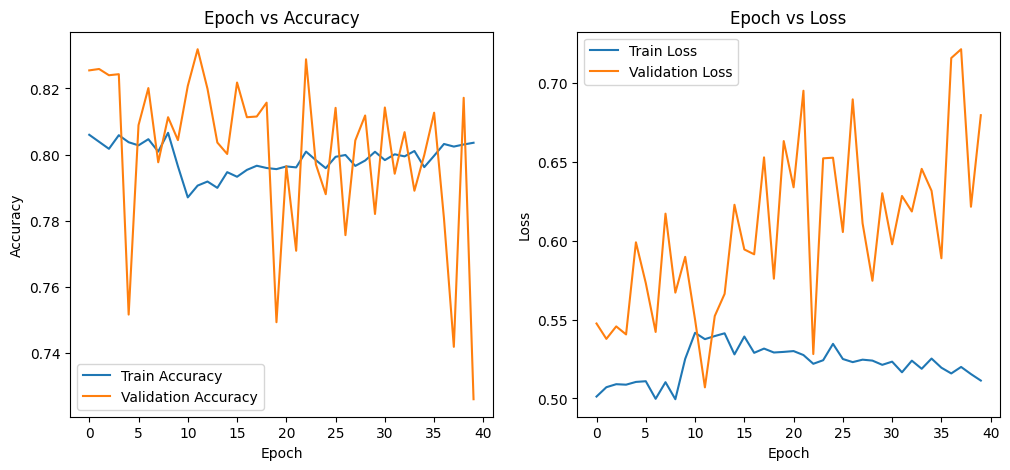

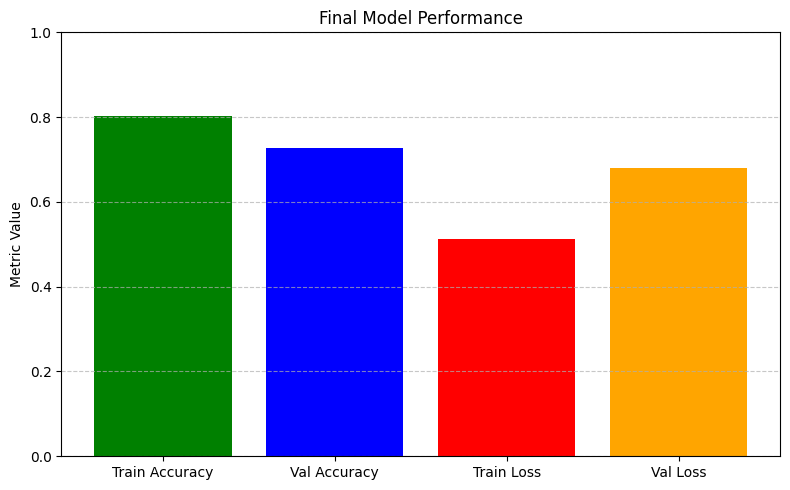

Training plots saved to 'training_plots.json' as base64-encoded PNG.


In [41]:
import matplotlib.pyplot as plt
import base64
import io
import json

# --- Fix input shape mismatch BEFORE training ---
X_sentiment_vader_train = X_sentiment_vader_train[:len(y_train_combined)]
X_sentiment_tfidf_lr_train = X_sentiment_tfidf_lr_train[:len(y_train_combined)]
X_bert_train = X_bert_train[:len(y_train_combined)]
X_metadata_train = X_metadata_train[:len(y_train_combined)]

# --- Fix test set too, if needed ---
X_sentiment_vader_test = X_sentiment_vader_test[:len(y_test_combined)]
X_sentiment_tfidf_lr_test = X_sentiment_tfidf_lr_test[:len(y_test_combined)]
X_bert_test = X_bert_test[:len(y_test_combined)]
X_metadata_test = X_metadata_test[:len(y_test_combined)]

# --- Create in-memory buffer for plots ---
plot_buffer = io.BytesIO()

# Start plot figure
plt.figure(figsize=(12, 5))

# --- Now train the model safely ---
history_sample = model_sample.fit(
    [X_bert_train, X_metadata_train, X_sentiment_vader_train, X_sentiment_tfidf_lr_train],
    y_train_combined,
    validation_data=([X_bert_test, X_metadata_test, X_sentiment_vader_test, X_sentiment_tfidf_lr_test], y_test_combined),
    epochs=epochs,
    batch_size=batch_size
)

# --- Plot Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(history_sample.history['accuracy'], label='Train Accuracy')
plt.plot(history_sample.history['val_accuracy'], label='Validation Accuracy')
plt.title('Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(history_sample.history['loss'], label='Train Loss')
plt.plot(history_sample.history['val_loss'], label='Validation Loss')
plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Extract final metrics
final_acc = history_sample.history['accuracy'][-1]
final_val_acc = history_sample.history['val_accuracy'][-1]
final_loss = history_sample.history['loss'][-1]
final_val_loss = history_sample.history['val_loss'][-1]

# Plot Bar Chart
plt.figure(figsize=(8, 5))
bar_labels = ['Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss']
bar_values = [final_acc, final_val_acc, final_loss, final_val_loss]
colors = ['green', 'blue', 'red', 'orange']

plt.bar(bar_labels, bar_values, color=colors)
plt.title('Final Model Performance')
plt.ylabel('Metric Value')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig(plot_buffer, format='png')
plt.close()

# Encode to base64 string
plot_buffer.seek(0)
plot_base64 = base64.b64encode(plot_buffer.read()).decode('utf-8')

# Save to JSON
with open('training_plots.json', 'w') as json_file:
    json.dump({'training_plot_base64': plot_base64}, json_file)

print("Training plots saved to 'training_plots.json' as base64-encoded PNG.")


In [ ]:
import numpy as np
print("Labels in the test sample (y_test_sample):")
print(np.unique(y_test_combined, return_counts=True))
print("Label Encoding Mapping:")
print(label_encoder.classes_)

In [ ]:
if 'df' in locals() and 'label' in df.columns:
    print("Value counts of 'label' in the DataFrame:")
    print(df['label'].value_counts())
    print("Label Encoding Mapping:")
    if 'label_encoder' in locals():
        print(label_encoder.classes_)
    else:
        print("LabelEncoder not defined.")
elif 'df_sample' in locals() and 'label' in df_sample.columns:
    print("Value counts of 'label' in the sample DataFrame:")
    print(df_sample['label'].value_counts())
    print("Label Encoding Mapping (for sample):")
    if 'label_encoder' in locals():
        print(label_encoder.classes_)
    else:
        print("LabelEncoder not defined.")
else:
    print("DataFrame or 'label' column not found.")

In [ ]:
# #Bert Embedding extraction with GPU optimization

# from transformers import BertTokenizer, TFBertModel
# import numpy as np
# import tensorflow as tf
# import time

# if 'df' in locals():
#     # Check for GPU availability and print device information
#     print("\nChecking available devices:")
#     gpus = tf.config.list_physical_devices('GPU')
#     if gpus:
#         print(f"GPU(s) detected: {len(gpus)}")
#         for gpu in gpus:
#             print(f"  {gpu}")
#         # Set memory growth to avoid consuming all GPU memory
#         try:
#             for gpu in gpus:
#                 tf.config.experimental.set_memory_growth(gpu, True)
#             print("Memory growth set to True for all GPUs")
#         except RuntimeError as e:
#             print(f"Error setting memory growth: {e}")
#     else:
#         print("No GPU found, using CPU.")
        
#     # Initialize BERT tokenizer and model
#     start_time = time.time()
#     print("\nInitializing BERT tokenizer and model...")
#     tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#     bert_base_model = TFBertModel.from_pretrained('bert-base-uncased')
#     print(f"BERT model initialized in {time.time() - start_time:.2f} seconds")

#     # --- GPU-Optimized BERT Embedding Extraction ---
#     def get_bert_embeddings_batched(texts, batch_size=64):
#         all_embeddings = []
#         total_batches = (len(texts) + batch_size - 1) // batch_size
#         start_time = time.time()
        
#         for i in range(0, len(texts), batch_size):
#             batch_idx = i // batch_size + 1
#             if batch_idx % 10 == 0 or batch_idx == 1:
#                 print(f"Processing batch {batch_idx}/{total_batches} - {batch_idx/total_batches*100:.1f}%")
                
#             batch_texts = texts[i:i + batch_size]
#             # Convert texts to tensors efficiently
#             inputs = tokenizer(batch_texts, padding='max_length', truncation=True, max_length=128, return_tensors="tf")
            
#             # Execute the model with tensor inputs
#             with tf.device('/GPU:0' if gpus else '/CPU:0'):
#                 outputs = bert_base_model(**inputs)
#                 # Immediately convert to numpy to free GPU memory
#                 batch_embeddings = outputs.pooler_output.numpy()
                
#             all_embeddings.extend(batch_embeddings)
            
#             # Optional: Clear TF memory between large batches
#             if batch_idx % 20 == 0:
#                 tf.keras.backend.clear_session()
                
#         elapsed = time.time() - start_time
#         print(f"Embedding extraction completed in {elapsed:.2f} seconds")
#         print(f"Average processing time per text: {elapsed/len(texts)*1000:.2f} ms")
#         return np.array(all_embeddings)

#     print("\nStarting GPU-optimized BERT embedding extraction...")
#     tweet_texts = df['tweet_text'].tolist()  # Convert to a list for easier batching
    
#     # Determine optimal batch size based on available GPU memory
#     # Smaller texts can use larger batches, larger texts should use smaller batches
#     avg_text_length = sum(len(text) for text in tweet_texts) / len(tweet_texts)
#     if gpus:
#         # Adjust batch size based on average text length
#         if avg_text_length < 50:
#             batch_size = 128
#         elif avg_text_length < 100:
#             batch_size = 64
#         else:
#             batch_size = 32
#     else:
#         # Smaller batch size for CPU to avoid memory issues
#         batch_size = 16
        
#     print(f"Using batch_size={batch_size} (avg text length: {avg_text_length:.1f} chars)")
#     X_bert_sample = get_bert_embeddings_batched(tweet_texts, batch_size=batch_size)
#     print("Batched BERT embeddings extracted.")
#     print(f"Shape of X_bert_sample: {X_bert_sample.shape}")
# else:
#     print("Error: DataFrame 'df' not found. Run the DataFrame loading part first.")

In [ ]:
# #Metadata preparation and feature combination

# from sklearn.preprocessing import StandardScaler
# import numpy as np

# if 'df_sample' in locals() and 'X_bert_sample' in locals() and 'X_sentiment_vader_sample' in locals() and 'X_sentiment_tfidf_lr' in locals():
#     # Prepare other features (metadata)
#     df_sample['tweet_length'] = df_sample['tweet_text'].apply(len)
#     df_sample['num_hashtags'] = df_sample['tweet_text'].str.count('#')
#     df_sample['num_mentions'] = df_sample['tweet_text'].str.count('@')
#     metadata_features = ['tweet_length', 'num_hashtags', 'num_mentions']
#     scaler = StandardScaler()
#     X_metadata_sample = scaler.fit_transform(df_sample[metadata_features])

#     # Combine all features
#     X_sample = np.concatenate([X_bert_sample, X_metadata_sample, X_sentiment_vader_sample, X_sentiment_tfidf_lr], axis=1)
#     y_sample = df_sample['label'].values
#     print("Shape of combined X_sample:", X_sample.shape)
# else:
#     print("Error: Ensure df_sample, X_bert_sample, X_sentiment_vader_sample, and X_sentiment_tfidf_lr are defined. Run previous snippets.")

In [ ]:
# #Metadata preparation and feature combination

# from sklearn.preprocessing import StandardScaler
# import numpy as np

# if 'df' in locals() and 'X_bert_sample' in locals() and 'X_sentiment_vader_sample' in locals() and 'X_sentiment_tfidf_lr_train' in locals() and 'X_sentiment_tfidf_lr_test' in locals() and 'X_train_text' in locals() and 'X_test_text' in locals():
#     # Prepare metadata features for the entire DataFrame
#     df['tweet_length'] = df['tweet_text'].apply(len)
#     df['num_hashtags'] = df['tweet_text'].str.count('#')
#     df['num_mentions'] = df['tweet_text'].str.count('@')
#     metadata_features = ['tweet_length', 'num_hashtags', 'num_mentions']
#     scaler = StandardScaler()
#     X_metadata = scaler.fit_transform(df[metadata_features])

#     # Separate metadata for train and test sets
#     df_train_metadata = df[df['tweet_text'].isin(X_train_text)][metadata_features]
#     df_test_metadata = df[df['tweet_text'].isin(X_test_text)][metadata_features]
#     X_metadata_train = scaler.transform(df_train_metadata)
#     X_metadata_test = scaler.transform(df_test_metadata)

#     # Combine all features for the training set
#     # Assuming X_bert_sample was generated for the entire dataset, we'll need to split it
#     from sklearn.model_selection import train_test_split
#     X_bert_train, X_bert_test, _, _ = train_test_split(X_bert_sample, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

#     # Similarly for VADER sentiment
#     df_vader = df[['tweet_text', 'vader_sentiment_score']]
#     df_vader_train = df_vader[df_vader['tweet_text'].isin(X_train_text)]['vader_sentiment_score'].values.reshape(-1, 1)
#     df_vader_test = df_vader[df_vader['tweet_text'].isin(X_test_text)]['vader_sentiment_score'].values.reshape(-1, 1)
#     X_train = np.concatenate([X_bert_train, X_metadata_train, df_vader_train, X_sentiment_tfidf_lr_train], axis=1)
#     y_train = df[df['tweet_text'].isin(X_train_text)]['label'].values
#     print("Shape of combined X_train:", X_train.shape)
#     print("Shape of y_train:", y_train.shape)

#     # Combine all features for the testing set
#     X_test = np.concatenate([X_bert_test, X_metadata_test, df_vader_test, X_sentiment_tfidf_lr_test], axis=1)
#     y_test = df[df['tweet_text'].isin(X_test_text)]['label'].values
#     print("Shape of combined X_test:", X_test.shape)
#     print("Shape of y_test:", y_test.shape)

# else:
#     print("Error: Ensure df, X_bert_sample, X_sentiment_vader_sample, X_sentiment_tfidf_lr_train, X_sentiment_tfidf_lr_test, X_train_text, and X_test_text are defined. Run previous snippets.")

In [ ]:
# #Data splitting simplified version

# from sklearn.model_selection import train_test_split

# if 'X_bert_sample' in locals() and 'X_metadata_sample' in locals() and 'X_sentiment_vader_sample' in locals() and 'X_sentiment_tfidf_lr_train' in locals() and 'X_sentiment_tfidf_lr_test' in locals() and 'df' in locals():
#     # --- Prepare Data for Splitting ---
#     # Combine features for the entire dataset
#     X_combined_full = np.concatenate([X_bert_sample, X_metadata_sample, X_sentiment_vader_sample, np.vstack((X_sentiment_tfidf_lr_train, X_sentiment_tfidf_lr_test))], axis=1)
#     y_full = df['label'].values

#     # Split the combined data with stratification
#     X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(
#         X_combined_full, y_full, test_size=0.2, random_state=42, stratify=y_full)
#     print("Combined features split (stratified).")
#     print(f"Shape of X_train_combined: {X_train_combined.shape}")
#     print(f"Shape of y_train_combined: {y_train_combined.shape}")
#     print(f"Shape of X_test_combined: {X_test_combined.shape}")
#     print(f"Shape of y_test_combined: {y_test_combined.shape}")

# else:
#     print("Error: Ensure X_bert_sample, X_metadata_sample, X_sentiment_vader_sample, X_sentiment_tfidf_lr_train, X_sentiment_tfidf_lr_test, and df are defined. Run previous snippets.")

In [ ]:
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
# from tensorflow.keras.models import Model
# import numpy as np  # Ensure NumPy is imported

# if 'X_bert_train_sample' in locals():
#     # Reshape the BERT embeddings
#     X_bert_train_reshaped = np.squeeze(X_bert_train_sample, axis=1)
#     X_bert_test_reshaped = np.squeeze(X_bert_test_sample, axis=1)

#     # Define a simpler Keras model using the pre-computed embeddings (for the sample)
#     bert_embedding_input = Input(shape=(X_bert_train_reshaped.shape[1],), name='bert_embedding') # Shape should be (None, 768)
#     meta_input = Input(shape=(X_meta_train_sample.shape[1],), name='metadata_input')
#     sentiment_input = Input(shape=(X_sent_train_sample.shape[1],), name='sentiment_input')

#     merged = Concatenate()([bert_embedding_input, meta_input, sentiment_input])
#     dense1 = Dense(128, activation='relu')(merged)
#     dropout1 = Dropout(0.5)(dense1)
#     output = Dense(len(label_encoder.classes_), activation='softmax')(dropout1)

#     model_sample = Model(inputs=[bert_embedding_input, meta_input, sentiment_input], outputs=output)
#     model_sample.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     print("Simplified hybrid model defined and compiled (using reshaped pre-computed embeddings from the sample).")
#     model_sample.summary()

#     # Train the model on the sample
#     epochs = 40
#     batch_size = 32
#     history_sample = model_sample.fit(
#         [X_bert_train_reshaped, X_meta_train_sample, X_sent_train_sample],
#         y_train_sample,
#         validation_data=([X_bert_test_reshaped, X_meta_test_sample, X_sent_test_sample], y_test_sample),
#         epochs=epochs,
#         batch_size=batch_size
#     )
#     print("Model training finished (on the sample).")
# else:
#     print("Error: BERT embeddings and split sample data not found. Please run the revised Snippet 6 successfully.")

In [ ]:
# from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
# from tensorflow.keras.models import Model
# import numpy as np  # Ensure NumPy is imported

# if 'X_bert_train' in locals() and 'X_metadata_train' in locals() and 'X_sentiment_vader_train' in locals() and 'X_sentiment_tfidf_lr_train' in locals() and 'y_train_combined' in locals() and 'X_bert_test' in locals() and 'X_metadata_test' in locals() and 'X_sentiment_vader_test' in locals() and 'X_sentiment_tfidf_lr_test' in locals() and 'y_test_combined' in locals() and 'label_encoder' in locals():
#     # --- Prepare Data ---
#     # BERT embeddings are likely already in the correct shape (None, 768)
#     bert_embedding_input_shape = X_bert_train.shape[1]
#     metadata_input_shape = X_metadata_train.shape[1]
#     sentiment_vader_input_shape = X_sentiment_vader_train.shape[1]
#     sentiment_tfidf_lr_input_shape = X_sentiment_tfidf_lr_train.shape[1]

#     # --- Define the Keras Model ---
#     bert_embedding_input = Input(shape=(bert_embedding_input_shape,), name='bert_embedding')
#     meta_input = Input(shape=(metadata_input_shape,), name='metadata_input')
#     sentiment_vader_input = Input(shape=(sentiment_vader_input_shape,), name='sentiment_vader_input')
#     sentiment_tfidf_lr_input = Input(shape=(sentiment_tfidf_lr_input_shape,), name='sentiment_tfidf_lr_input')
#     merged = Concatenate()([bert_embedding_input, meta_input, sentiment_vader_input, sentiment_tfidf_lr_input])
#     dense1 = Dense(256, activation='relu')(merged)
#     dropout1 = Dropout(0.5)(dense1)
#     dense2 = Dense(128, activation='relu')(dropout1)
#     dropout2 = Dropout(0.5)(dense2)
#     output = Dense(len(label_encoder.classes_), activation='softmax')(dropout2)
#     model_combined = Model(inputs=[bert_embedding_input, meta_input, sentiment_vader_input, sentiment_tfidf_lr_input], outputs=output)
#     model_combined.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     print("Hybrid model defined and compiled (using combined features).")
#     model_combined.summary()

#     # --- Train the Model ---
#     epochs = 40
#     batch_size = 32
#     history_combined = model_combined.fit(
#         [X_bert_train, X_metadata_train, X_sentiment_vader_train, X_sentiment_tfidf_lr_train],
#         y_train_combined,
#         validation_data=([X_bert_test, X_metadata_test, X_sentiment_vader_test, X_sentiment_tfidf_lr_test], y_test_combined),
#         epochs=epochs,
#         batch_size=batch_size)
#     print("Model training finished (on combined features).")

# else:
#     print("Error: Combined training and testing data not found. Please ensure Snippet 6 (or the feature combination step) ran successfully.")

In [ ]:
# #Model performance metrics

# from sklearn.metrics import classification_report
# import numpy as np

# if 'model_sample' in locals() and 'X_bert_test_sample' in locals():
#     # Reshape the test BERT embeddings for prediction
#     X_bert_test_reshaped = np.squeeze(X_bert_test_sample, axis=1)

#     # Evaluate the model on the sample
#     y_pred_probs_sample = model_sample.predict([X_bert_test_reshaped, X_meta_test_sample, X_sent_test_sample])
#     y_pred_sample = np.argmax(y_pred_probs_sample, axis=1)

#     print("\nClassification Report (using pre-computed embeddings from the sample):")
#     print(classification_report(y_test_sample, y_pred_sample, target_names=label_encoder.classes_))
# else:
#     print("Error: The model for the sample is not defined or test data is missing. Please run Snippets 8 and ensure Snippet 6 ran successfully.")

In [ ]:
# #Model performance metrics

# from sklearn.metrics import classification_report
# import numpy as np
# import matplotlib.pyplot as plt

# if 'model_sample' in locals() and 'X_bert_test_sample' in locals() and 'history_sample' in locals():
#     # Reshape the test BERT embeddings for prediction
#     X_bert_test_reshaped = np.squeeze(X_bert_test_sample, axis=1)

#     # Evaluate the model on the sample
#     y_pred_probs_sample = model_sample.predict([X_bert_test_reshaped, X_meta_test_sample, X_sent_test_sample])
#     y_pred_sample = np.argmax(y_pred_probs_sample, axis=1)
#     print("\nClassification Report (using pre-computed embeddings from the sample):")
#     print(classification_report(y_test_sample, y_pred_sample, target_names=label_encoder.classes_))

#     # --- Plotting Training History ---
#     plt.figure(figsize=(12, 5))

#     # Plot Accuracy
#     plt.subplot(1, 2, 1)
#     plt.plot(history_sample.history['accuracy'], label='Train Accuracy')
#     plt.plot(history_sample.history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Epoch vs Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     # Plot Loss
#     plt.subplot(1, 2, 2)
#     plt.plot(history_sample.history['loss'], label='Train Loss')
#     plt.plot(history_sample.history['val_loss'], label='Validation Loss')
#     plt.title('Epoch vs Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# else:
#     print("Error: The model for the sample is not defined or test data/training history is missing. Please run Snippets 8 and ensure Snippets 6 and 9 ran successfully.")plt.legend()
#     plt.tight_layout()
#     plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# import base64
# import io
# import json

# # --- Create in-memory buffer for plots ---
# plot_buffer = io.BytesIO()

# # Recreate and save the plot to buffer
# plt.figure(figsize=(12, 5))

# history_sample = model_sample.fit(
#     [X_bert_train, X_metadata_train, X_sentiment_vader_train, X_sentiment_tfidf_lr_train],
#     y_train_combined,
#     validation_data=([X_bert_test, X_metadata_test, X_sentiment_vader_test, X_sentiment_tfidf_lr_test], y_test_combined),
#     epochs=epochs,
#     batch_size=batch_size
#     )

# X_sentiment_vader_train = X_sentiment_vader_train[:len(y_train_combined)]


# # Plot Accuracy
# plt.subplot(1, 2, 1)
# plt.plot(history_sample.history['accuracy'], label='Train Accuracy')
# plt.plot(history_sample.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Epoch vs Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# # Plot Loss
# plt.subplot(1, 2, 2)
# plt.plot(history_sample.history['loss'], label='Train Loss')
# plt.plot(history_sample.history['val_loss'], label='Validation Loss')
# plt.title('Epoch vs Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()

# plt.tight_layout()
# plt.savefig(plot_buffer, format='png')
# plt.close()

# print(f"BERT shape: {X_bert_train.shape}")
# print(f"Metadata shape: {X_metadata_train.shape}")
# print(f"VADER shape: {X_sentiment_vader_train.shape}")
# print(f"TF-IDF shape: {X_sentiment_tfidf_lr_train.shape}")
# print(f"Labels shape: {y_train_combined.shape}")


# # Encode to base64 string
# plot_buffer.seek(0)
# plot_base64 = base64.b64encode(plot_buffer.read()).decode('utf-8')

# # Save to JSON
# with open('training_plots.json', 'w') as json_file:
#     json.dump({'training_plot_base64': plot_base64}, json_file)

# print("Training plots saved to 'training_plots.json' as base64-encoded PNG.")
